In [1]:
%reload_ext autoreload
%autoreload 2

In [22]:
from ripple_heterogeneity.replay import replay_run, replay_fig, replay_participation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nelpy as nel
import nelpy.plotting as npl
from scipy import stats

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
    add_new_deep_sup,
    custom_plots
)

In [315]:
basepath = 'Z:\\Data\\HMC1\\day9'

cell_metrics, data, ripples, fs_dat = loading.load_basic_data(basepath)

restrict_idx = (
    (cell_metrics.putativeCellType == "Pyramidal Cell")
    & (cell_metrics.brainRegion.str.contains("CA1"))
    & (cell_metrics.bad_unit == False)
    & (cell_metrics.total >= 100)
)
# restrict cell metrics
cell_metrics = cell_metrics[restrict_idx]

# load session epoch data
epoch_df = loading.load_epoch(basepath)
# get session bounds to provide support
session_bounds = nel.EpochArray(
    [epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[-1]]
)
# load session epoch data
epoch_df = loading.load_epoch(basepath)
# get session bounds to provide support
session_bounds = nel.EpochArray(
    [epoch_df.startTime.iloc[0], epoch_df.stopTime.iloc[-1]]
)
# compress repeated sleep sessions
epoch_df = compress_repeated_epochs.main(epoch_df)
# put into nel format
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

try:
    st_all = nel.SpikeTrainArray(
        timestamps=np.array(data["spikes"], dtype=object)[restrict_idx], fs=fs_dat
    )
except:
    st_all = nel.SpikeTrainArray(
        timestamps=np.array(data["spikes"], dtype=object)[restrict_idx][0],
        fs=fs_dat,
    )

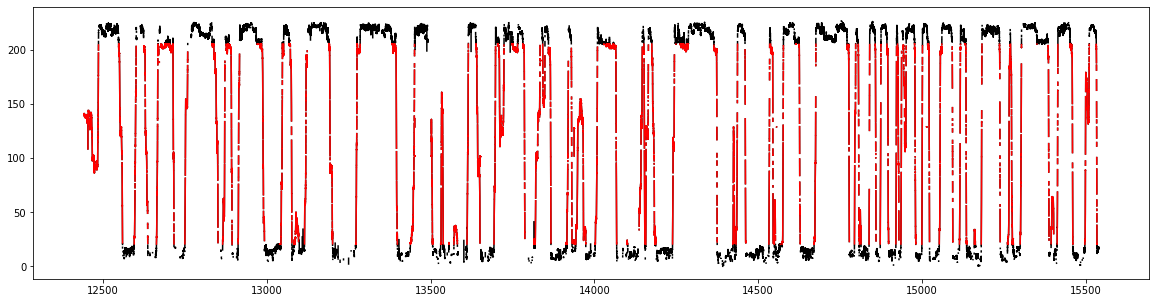

In [180]:
beh_df = loading.load_animal_behavior(basepath)
plt.figure(figsize=(20, 5))
beh_df.linearized = beh_df.linearized - beh_df.linearized.min()
plt.plot(beh_df.time, beh_df.linearized,'k')

beh_df.loc[beh_df.linearized > beh_df.linearized.max()*.9,"linearized"] = np.nan
beh_df.loc[beh_df.linearized < beh_df.linearized.max()*.1,"linearized"] = np.nan
plt.plot(beh_df.time, beh_df.linearized,'r')

In [316]:
pos, outbound_epochs, inbound_epochs = replay_run.handle_behavior(
    basepath,
    epoch_df,
    beh_epochs,
    manipulation_epochs=None,
    restrict_manipulation=False,
    session_bounds=session_bounds,
    smooth=False,
    resample_fs=30,
    good_laps=True,
    remove_track_ends=False,
)

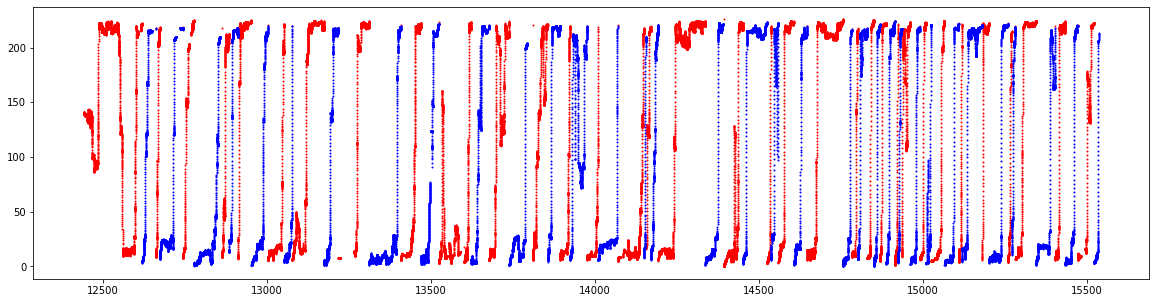

In [317]:
plt.figure(figsize=(20, 5))
plt.scatter(pos[outbound_epochs].abscissa_vals, pos[outbound_epochs].data.T,color='r',s=1)
plt.scatter(pos[inbound_epochs].abscissa_vals, pos[inbound_epochs].data.T,color='b',s=1)

In [340]:
traj_shuff=1500 # number of shuffles to determine sig replay
behav_shuff=250 # number of shuffles to determine sig decoding
ds_50ms=0.05 # bin width to bin st for tuning curve
s_binsize=3 # spatial bins in tuning curve
speed_thres=4 # running threshold to determine tuning curves
min_rip_dur=0.08 # min ripple duration for replay
place_cell_min_rate=1 # min peak rate of tuning curve
place_cell_min_spks=100 # at least 100 spikes while running above speed_thres
place_cell_peak_mean_ratio=1 # peak firing rate / mean firing rate
replay_binsize=0.02 # bin size to decode replay
tuning_curve_sigma=3 # 3 cm sd of smoothing on tuning curve
expand_canidate_by_mua=False # whether to expand candidate units by mua (note: will only take rips with mua)
restrict_manipulation=False # whether to restrict manipulation epochs
shuffle_parallel=True
ds_beh_decode=0.2 # bin width to bin st behavioral decoding



In [341]:
tc, st_run, bst_run = replay_run.get_tuning_curves(
    pos, st_all, outbound_epochs, speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
)

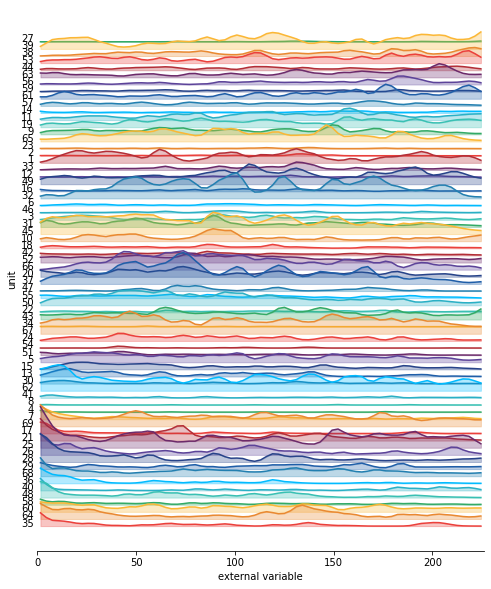

In [342]:
tc = tc.reorder_units()
npl.set_palette(npl.colors.rainbow)
with npl.FigureManager(show=True, figsize=(8, 10)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    npl.plot_tuning_curves1D(tc, normalize=False, pad=3)


In [343]:
(
    sta_placecells,
    tc,
    bst_run,
    cell_metrics_,
    total_units,
) = replay_run.restrict_to_place_cells(
    tc,
    st_run,
    bst_run,
    st_all,
    cell_metrics,
    place_cell_min_spks,
    place_cell_min_rate,
    place_cell_peak_mean_ratio,
)

In [358]:
bst_run_beh, bst_run_beh[outbound_epochs]

(<BinnedSpikeTrainArray at 0x1403d8caa00: 50 series in 139,604 bins of width 200.0 milliseconds> for a total of 7:45:20:800 hours,
 <BinnedEventArray at 0x1404149d970: 50 series (35 segments) in 8,303 bins of width 200.0 milliseconds> for a total of 27:40:600 minutes)

In [360]:
bst_run_beh = sta_placecells[outbound_epochs].bin(ds=ds_beh_decode)
decoding_r2, median_error, decoding_r2_shuff, _ = replay_run.decode_and_shuff(
    bst_run_beh, tc, pos[outbound_epochs], n_shuffles=10
)
decoding_r2, median_error, decoding_r2_shuff

(0.6895359114408401,
 9.903082172744583,
 array([[-0.03782755],
        [ 0.00059174],
        [-0.00735541],
        [-0.04009575],
        [-0.01126545],
        [-0.04984531],
        [-0.02771151],
        [-0.0149474 ],
        [-0.00605718],
        [ 0.01220918]]))

In [361]:
posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
    bst_run_beh, tc, xmin=np.nanmin(pos[outbound_epochs].data), xmax=np.nanmax(pos[outbound_epochs].data)
)

In [362]:
mode_pth.shape, posteriors.shape, pos[outbound_epochs](bst_run_beh.bin_centers).shape

((8283,), (75, 8283), (8283,))

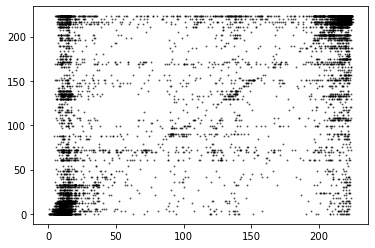

In [366]:
posteriors, lengths, mode_pth, mean_pth = nel.decoding.decode1D(
    bst_run_beh, tc, xmin=np.nanmin(pos[outbound_epochs].data), xmax=np.nanmax(pos[outbound_epochs].data)
)
actual_pos = pos[outbound_epochs](bst_run_beh.bin_centers)
bad_idx = np.isnan(actual_pos) | np.isnan(mode_pth)
actual_pos = actual_pos[~bad_idx]
mode_pth = mode_pth[~bad_idx]
slope, intercept, rvalue, pvalue, stderr = stats.linregress(actual_pos, mode_pth)
median_error = np.nanmedian(np.abs(actual_pos - mode_pth))

plt.scatter(actual_pos,mode_pth,color='k',alpha=.5,s=1)


In [346]:
pos[outbound_epochs](bst_run_beh.bin_centers)

array([nan, nan, nan, ..., nan, nan, nan])

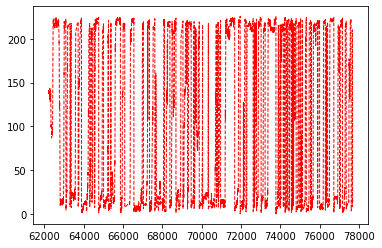

In [347]:
pos[outbound_epochs](bst_run_beh.bin_centers)
plt.plot(pos(bst_run_beh.bin_centers), "r", linewidth=1, linestyle="--")

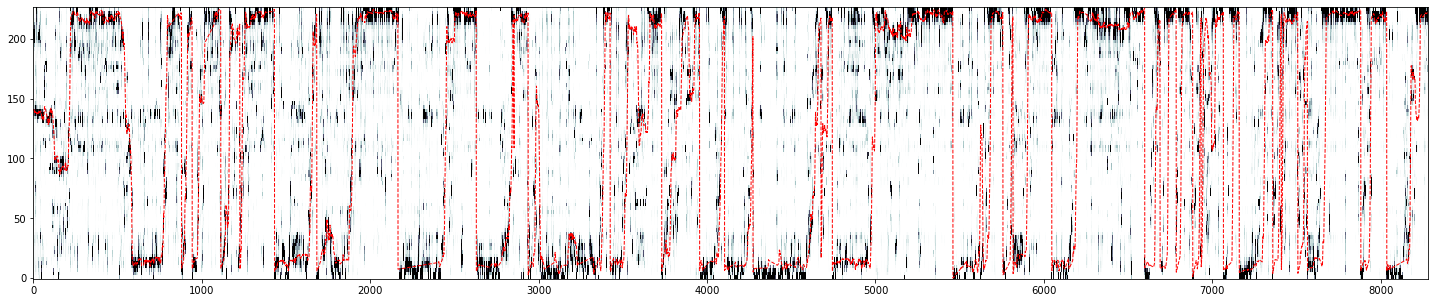

In [363]:
from nelpy.plotting.core import imagesc

fig = plt.figure(figsize=(25, 5))
ax = plt.gca()
n_ext, n_bins = posteriors.shape
imagesc(
    x=np.arange(n_bins),
    y=np.arange(int(tc.bins[-1] + 1)),
    data=posteriors,
    cmap="bone_r",
    ax=ax,
    vmax=0.1,
)
actual_pos = pos[outbound_epochs](bst_run_beh.bin_centers)

# bad_idx = np.isnan(actual_pos)
# actual_pos = actual_pos[~bad_idx]
plt.plot(actual_pos, "r", linewidth=1, linestyle="--")

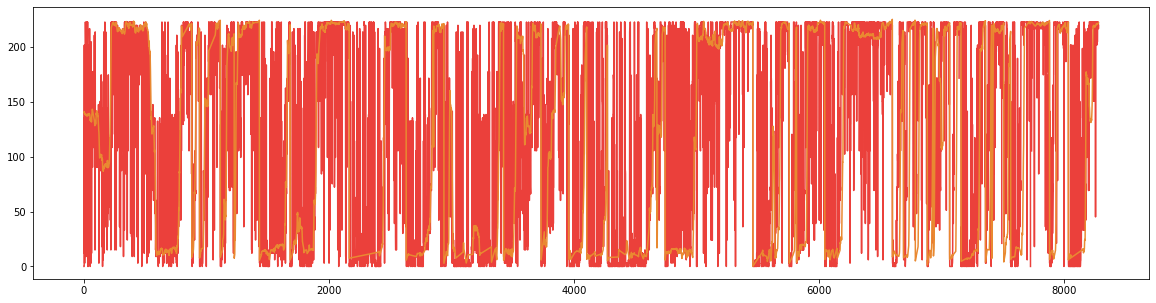

In [364]:
plt.figure(figsize=(20, 5))
plt.plot(mode_pth)

plt.plot(actual_pos)

(0.0, 1000.0)

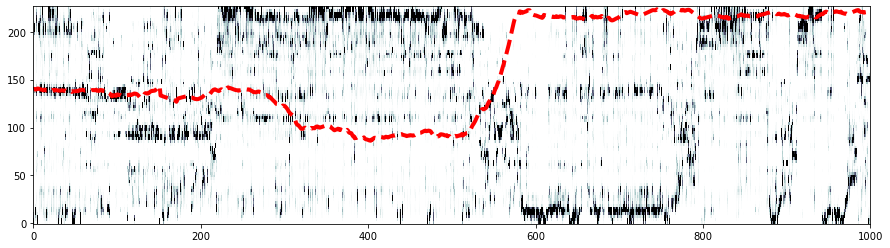

In [365]:
fig = plt.figure(figsize=(15, 4))
ax = plt.gca()
n_ext, n_bins = posteriors.shape
imagesc(
    x=np.arange(n_bins),
    y=np.arange(int(tc.bins[-1] + 1)),
    data=posteriors,
    cmap="bone_r",
    ax=ax,
    vmax=0.1,
)

plt.plot(pos[outbound_epochs](bst_run.bin_centers), "r", linewidth=4, linestyle="--")
plt.xlim(0, 1000)

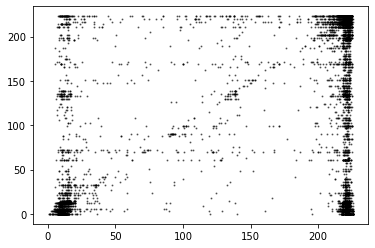

In [134]:
median_error

33.30800294632604